## Transaction Fraud detection

1. >import transaction data
2. >Clean Data (remove null values, etc)
3. >Perform feature selection
4. >Normalize each column of the data (this is to reduce the dimension or size of the dataset while still preserving
   the key properties of the data)
5. >Transform each transaction into its corresponding signature representation
    a) Build a universal set of transactions by feeding all transactions into it
    b) calculate the mean and standard deviation from this dataset
    c) construct a gaussian distribution from which **hyperplanes** will be derived
6. >generate a hashtable  of randomly generated hash planes from gaussian distribution in a) above
7. > if for each plane if a transaction is >=0 we put a value of 1 else 0 we end with a binary signature representation of the transaction.
8. > Divide signatures to  **B** bands of **r** rows each.
9. > hash bands into buckets.(elements in the same bucket are regarded as being identical
10. > Testing phase.


## Import all necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### 1.Import transaction data

In [2]:
#testing one hot encoding
#df=pd.Series(list('abca'))
#oneHot=pd.get_dummies(df)
#print(oneHot)
df=pd.DataFrame({
    'A':['a','b','a','d'],
    'B':['b','a','d','c']
})
#print(df)
hot=pd.get_dummies(df['A'])
#df=df.drop('A',axis=1)
df=df.join(hot)
print(df)

   A  B  a  b  d
0  a  b  1  0  0
1  b  a  0  1  0
2  a  d  1  0  0
3  d  c  0  0  1


In [3]:
data=pd.read_csv('../Dataset/transactions/dataset.csv',nrows=1000)
data.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
#Calculating the percentage of fraudulent transactions
#print(data.type.value_counts())
#df[data['isFraud']==1].count()
fraud=sum(data['isFraud'])
total=6353307
print((fraud/total)*100)
print(fraud)


0.00014165850949749478
9


In [49]:
#len(df[data['type']=='TRANSFER'])
newdata=data.loc[data['type']=="TRANSFER"]

In [50]:
newdata.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0


In [51]:
#calculating the total percentage of fraud in transfer
fraud=sum(newdata['isFraud'])
total=532021
print((fraud/total)*100)
print(fraud)

0.010713862798648926
57


In [52]:
max(data['amount'])

10000000.0

In [53]:
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.4+ MB


In [54]:
#performing one-Hot encoding of the type column since its categorical data
oneHot=pd.get_dummies(data['type'])
print(oneHot)
data

       CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER
0            0         0      0        1         0
1            0         0      0        1         0
2            0         0      0        0         1
3            0         1      0        0         0
4            0         0      0        1         0
...        ...       ...    ...      ...       ...
99995        0         0      0        1         0
99996        0         0      0        1         0
99997        1         0      0        0         0
99998        0         1      0        0         0
99999        0         0      0        1         0

[100000 rows x 5 columns]


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,10,PAYMENT,4020.66,C1410794718,159929.0,155908.34,M1257036576,0.00,0.00,0,0
99996,10,PAYMENT,18345.49,C744303677,6206.0,0.00,M1785344556,0.00,0.00,0,0
99997,10,CASH_IN,183774.91,C104331851,39173.0,222947.91,C36392889,54925.05,0.00,0,0
99998,10,CASH_OUT,82237.17,C707662966,6031.0,0.00,C1553004158,592635.66,799140.46,0,0


In [55]:
#drop some None useful columns
print(data.columns)
data=data.drop(['nameOrig','nameDest','isFlaggedFraud','step'],axis=1)

data.head()

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [56]:
#drop the type column from dataset and add the one-hot encoded columms to the dataset
data=data.drop('type',axis=1)
data=data.join(oneHot)
data.head()
data[0:2]

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0


In [57]:
data.std()

amount            3.443003e+05
oldbalanceOrg     2.673284e+06
newbalanceOrig    2.711318e+06
oldbalanceDest    2.402267e+06
newbalanceDest    2.802350e+06
isFraud           3.403918e-02
CASH_IN           4.013828e-01
CASH_OUT          4.613270e-01
DEBIT             9.890644e-02
PAYMENT           4.888789e-01
TRANSFER          2.803211e-01
dtype: float64

In [58]:
data.columns
print(data.columns)
y_data=data['isFraud']
x_data=data[['amount','oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT','TRANSFER']]
x_data.head()

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT',
       'TRANSFER'],
      dtype='object')


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


In [59]:
x_data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


In [60]:
data=x_data.join(y_data)
data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0,0
2,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1,1
3,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0,1
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0,0


<AxesSubplot: >

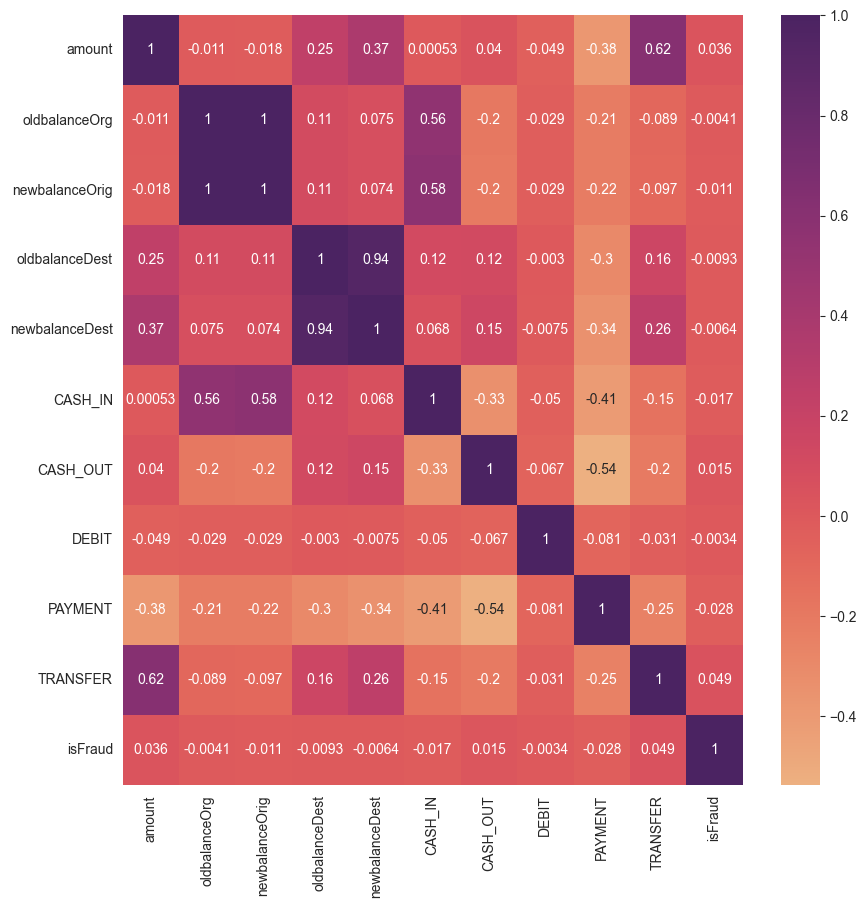

In [61]:

data.describe()
s=data.corr()
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(s,annot=True,cmap='flare')

In [62]:
from sklearn.model_selection import train_test_split
train, test =train_test_split(data,train_size=0.75,random_state=42)
data.head()
train.shape
test.shape
x_train=train[['amount','oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT','TRANSFER']]
y_train=train[['isFraud']]
x_test=test[['amount','oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT','TRANSFER']]
y_test=test[['isFraud']]

print(x_train.shape,x_test.shape,y_test.shape,y_train.shape)

(75000, 10) (25000, 10) (25000, 1) (75000, 1)


## performing some machine learning Algorithms on the data


#### A)  Linear regression

In [63]:
from sklearn.linear_model import LogisticRegression
lgr=LogisticRegression()
lgr.fit(x_train,y_train)


C:\Users\Cyanide Inc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

### B) Support Vector Machine (SVM)

In [64]:
#from sklearn.tree import DecisionTreeClassifier

#clf_dec = DecisionTreeClassifier()
#clf_dec.fit(x_train, y_train)

In [65]:
from sklearn.naive_bayes import GaussianNB
gcl=GaussianNB()
gcl.fit(x_train,y_train)

C:\Users\Cyanide Inc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [66]:
### Testing prediction accurrary
lScore=lgr.score(x_test,y_test)
#svmScore=clf_svm.score(x_test,y_test)
decTreeScore=clf_dec.score(x_test,y_test)
gclScore=gcl.score(x_test,y_test)


print(f"linear regression: {lScore}")
#print(f"SVM: {svmScore}")
print(f"Decision Tree: {decTreeScore}")
print(f"Gaussian classifier: {gclScore}")


NameError: name 'clf_dec' is not defined

In [67]:

from sklearn.metrics import f1_score
print(f1_score(y_test,lgr.predict(x_test),average=None))
#print(f1_score(y_test,svm.predict(x_test),average=None,labels=["isFraud","notFraud"]))
print(f1_score(y_test,gcl.predict(x_test),average=None))
print(f1_score(y_test,clf_dec.predict(x_test),average=None))

[0.99975972 0.79310345]
[0.99046927 0.00840336]


NameError: name 'clf_dec' is not defined

In [68]:
x_test.shape

(25000, 10)

In [69]:
predictions=lgr.predict(x_test)
print(predictions)
print(y_test['isFraud'])

[0 0 0 ... 0 0 0]
75721    0
80184    0
19864    0
76699    0
92991    0
        ..
21271    0
34014    0
81355    0
65720    0
11627    0
Name: isFraud, Length: 25000, dtype: int64


In [70]:

for i in range(len(predictions)):
    print(f"{predictions[i]}---->{y_test[i]}")

KeyError: 0

### 2.Clean Data (remove null values, etc)

In [ ]:
# Testing for null values in our entire dataset
True in data.isnull()


### 3. Perform feature selection

#### a) Using XGBClassifier

In [71]:
from xgboost import XGBClassifier
#from xgb import XGBRegressor()
model=XGBClassifier()
#predefined data and labels(for regression)
model.fit(x_train,y_train)

#print array of feature importance
print('Feature importances:\n{}'.format(repr(model.feature_importances_)))


Feature importances:
array([0.06343695, 0.0640121 , 0.08123506, 0.10890616, 0.05163081,
       0.04504401, 0.11181554, 0.        , 0.41236228, 0.06155708],
      dtype=float32)


In [72]:
print(model.feature_importances_)


[0.06343695 0.0640121  0.08123506 0.10890616 0.05163081 0.04504401
 0.11181554 0.         0.41236228 0.06155708]


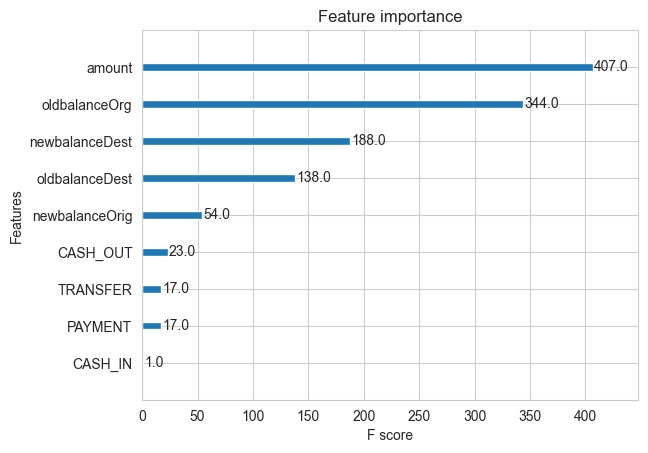

<Figure size 640x480 with 0 Axes>

In [73]:
from  xgboost import plot_importance
#plot_importance(model)
plot_importance(model,importance_type='weight')
#plot_importance(model,importance_type='gain',show_values=False)
plt.show()#matplotlib plot
plt.savefig('importance.png')#save plot to png file
# the resultign plot is a bar chat of F1 scores for each feature
## importance type is set ot gain since we want the information gain to be the matrix for evaluating feature importance

#### b) Univariant feature selection(with chi square test)

In [74]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


#applying selectBest to get K best features
bestfeatures=SelectKBest(score_func=chi2,k=1)
fit=bestfeatures.fit(x_train,y_train)
dfscore=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(x_train.columns)
dfpvalues=pd.DataFrame(fit.pvalues_)

In [75]:
#concatenate 2 dataframes for better observation
featureScores=pd.concat([dfcolumns,dfscore,dfpvalues],axis=1)
featureScores.columns=["Features","Score","p-values"]
featureScores

,Features,Score,p-values
0,amount,9.702527e+07,0.000000e+00
1,oldbalanceOrg,6.956044e+06,0.000000e+00
2,newbalanceOrig,7.489951e+07,0.000000e+00
3,oldbalanceDest,3.640475e+07,0.000000e+00
4,newbalanceDest,1.000451e+07,0.000000e+00
5,CASH_IN,1.830715e+01,1.880006e-05
6,CASH_OUT,1.877246e+01,1.472787e-05
7,DEBIT,8.600836e-01,3.537153e-01
8,PAYMENT,3.606034e+01,1.913010e-09
9,TRANSFER,1.336622e+02,6.477038e-31


In [76]:
print(featureScores.nlargest(6,'p-values')) #print the 6 most important features

   Features         Score      p-values
7     DEBIT  8.600836e-01  3.537153e-01
5   CASH_IN  1.830715e+01  1.880006e-05
6  CASH_OUT  1.877246e+01  1.472787e-05
8   PAYMENT  3.606034e+01  1.913010e-09
9  TRANSFER  1.336622e+02  6.477038e-31
0    amount  9.702527e+07  0.000000e+00


#### c) Using feature importance from a tree based classifier

In [77]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
modelTree=ExtraTreesClassifier()
modelTree.fit(x_train,y_train)

C:\Users\Cyanide Inc\AppData\Local\Temp\ipykernel_13744\1380844732.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelTree.fit(x_train,y_train)


ExtraTreesClassifier()

In [78]:
print(modelTree.feature_importances_) #using inbuild class feature importance of tree based classifiers

[3.02315254e-01 2.94270081e-01 5.90147489e-02 1.54299346e-01
 1.82691972e-01 4.52874927e-04 2.63370589e-03 1.22165803e-04
 4.76723929e-04 3.72312815e-03]


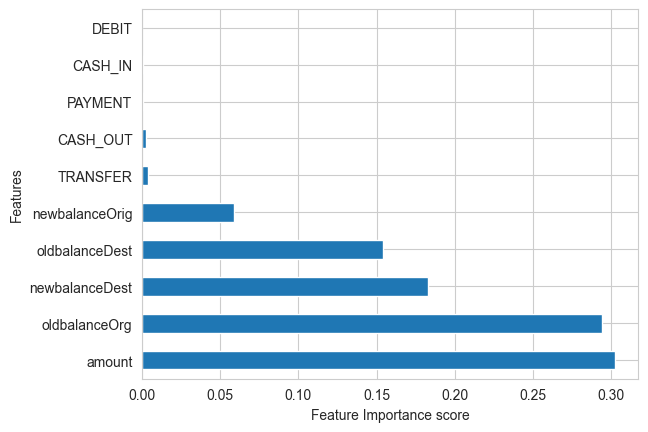

In [79]:
#plot graph of feature importcance for better visualization
feat_importance=pd.Series(modelTree.feature_importances_,index=x_train.columns)
feat_importance.nlargest(10).plot(kind='barh')
plt.ylabel("Features")
plt.xlabel("Feature Importance score")
#plt.title("Feature importance chart for Treebase classifier")
plt.show()

In [80]:
print(featureScores.nlargest(6,'Score'))

         Features         Score      p-values
0          amount  9.702527e+07  0.000000e+00
2  newbalanceOrig  7.489951e+07  0.000000e+00
3  oldbalanceDest  3.640475e+07  0.000000e+00
4  newbalanceDest  1.000451e+07  0.000000e+00
1   oldbalanceOrg  6.956044e+06  0.000000e+00
9        TRANSFER  1.336622e+02  6.477038e-31



#### d) Using feature importance from a tree based classifier

In [81]:
data.isFraud.value_counts()

0    99884
1      116
Name: isFraud, dtype: int64

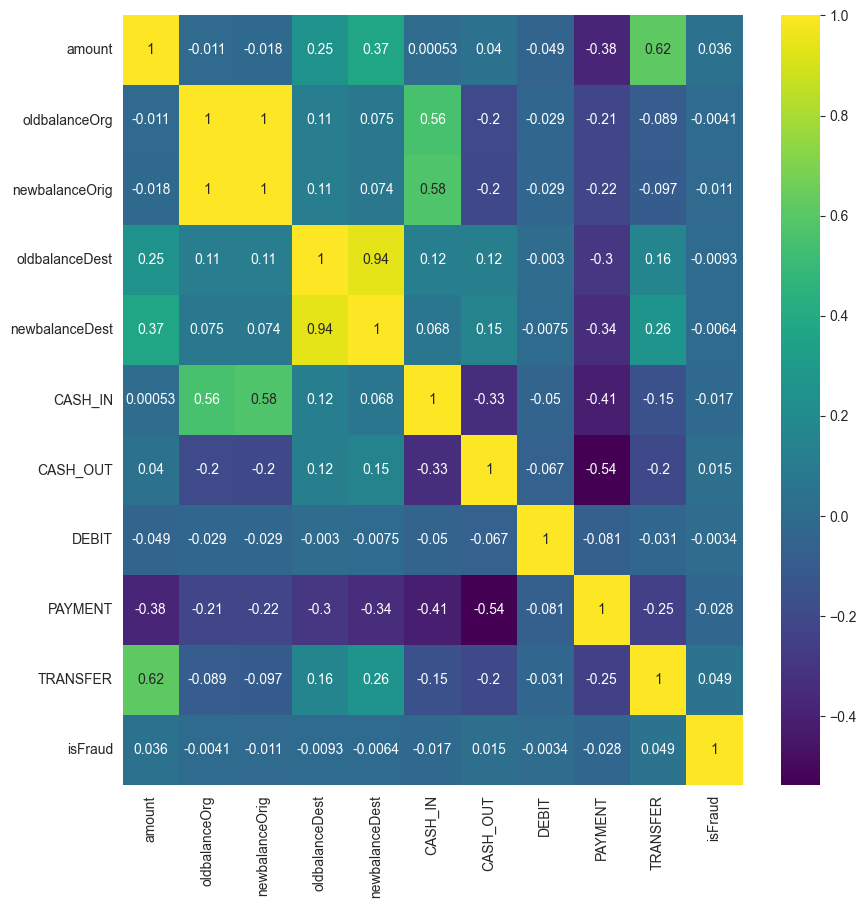

In [82]:
import seaborn as sns
#getting correlation of each feature in dataset
cormat=data.corr()
top_corr_features=cormat.index
plt.figure(figsize=(10,10))
#plot heatmap
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap='viridis')

### e) Information Gain

In [83]:
from sklearn.feature_selection import mutual_info_classif
x_train.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
98980,487238.26,0.0,0.00,751505.6,1238743.86,0,1,0,0,0
69824,30894.63,22851.0,53745.63,4152.5,0.00,1,0,0,0,0
9928,53459.12,0.0,0.00,70971.0,0.00,0,1,0,0,0
75599,8035.57,0.0,0.00,0.0,0.00,0,0,0,1,0
95621,5934.31,10330.0,4395.69,0.0,0.00,0,0,0,1,0


In [84]:
features=x_train
target=y_train
feature_score=mutual_info_classif(features,target,random_state=0)
print(x_train.columns)
feature_score

C:\Users\Cyanide Inc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT',
       'TRANSFER'],
      dtype='object')


array([1.07386665e-03, 1.12414747e-03, 7.80289629e-04, 3.62402762e-04,
       3.27100485e-04, 2.43004908e-03, 4.95061482e-03, 2.29026604e-05,
       8.68275861e-03, 9.14541748e-04])

### Performing features scaling and normalization

In [85]:

x_train_selected=x_train[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','TRANSFER']]
x_train_selected.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,TRANSFER
98980,487238.26,0.0,0.00,751505.6,1238743.86,0
69824,30894.63,22851.0,53745.63,4152.5,0.00,0
9928,53459.12,0.0,0.00,70971.0,0.00,0
75599,8035.57,0.0,0.00,0.0,0.00,0
95621,5934.31,10330.0,4395.69,0.0,0.00,0


In [86]:
x_train_selected['amount']

98980    487238.26
69824     30894.63
9928      53459.12
75599      8035.57
95621      5934.31
           ...    
6265      11136.27
54886     30863.42
76820    390129.56
860       96178.80
15795      7694.26
Name: amount, Length: 75000, dtype: float64

##### 1.) Standardizing the data using column wise scaling

In [87]:
from sklearn.preprocessing import scale
x_train_selected_scaled=scale(x_train_selected)
#x_train_selected_standardized.std(axis=0)
#x_train_selected_standardized.mean(axis=0)


##### 2.) Row base Normalizing  of the data

In [88]:
from sklearn.preprocessing import Normalizer
normalizer=Normalizer()
#Nb we can normalize the already scaled data. as well as we can normalize the unscaled data but prefereable we normalized the scaled data
x_train_selected_scaled_Normalized=normalizer.fit_transform(x_train_selected_scaled)
x_train_selected_scaled_Normalized.shape



(75000, 6)

In [89]:
x_train_selected.head()
x_train_selected.shape

(75000, 6)

 ## Based on analysis of feature selection techniques we will us the following feature for training our model.

4. Balance the data using SMOTETOMIC OR ANY OTHER TECHNIQUE

In [90]:
#from sklearn import svm

#clf_svm = svm.SVC(kernel='linear')

#clf_svm.fit(x_train,y_train)

6. >Transform each transaction into its corresponding signature representation

    a) Build a universal set of transactions by feeding all transactions into it

In [91]:
x_train_selected_scaled_Normalized.tolist()
#Transform data into numpy array so we can easily get the mean and standard deviation of the data
x_train_selected_scaled_Normalized=np.array(x_train_selected_scaled_Normalized.tolist())
x_train_selected_scaled_Normalized

array([[ 0.85335763, -0.30561594, -0.30686161, -0.05100655,  0.01680705,
        -0.2851867 ],
       [-0.46962529, -0.36212993, -0.35089011, -0.41534749, -0.48197938,
        -0.34694735],
       [-0.40887205, -0.38478913, -0.3863575 , -0.39716664, -0.49881666,
        -0.35906747],
       ...,
       [ 0.76756587, -0.33504981, -0.39947169, -0.01783525, -0.02929148,
        -0.37125535],
       [-0.29684964, -0.4346563 , -0.43642793, -0.42597776, -0.43187435,
        -0.40560121],
       [-0.55916763, -0.25684256, -0.26341954, -0.42715493, -0.49334937,
        -0.35513191]])

In [92]:
testTransaction=x_train_selected_scaled_Normalized[2]
testTransaction

array([-0.40887205, -0.38478913, -0.3863575 , -0.39716664, -0.49881666,
       -0.35906747])

In [93]:
universalSet=np.array([]) #initially this universalSet is empty

def buildWeightsOfUniversalSet(weightedDocuments,universalSet):
    #input: a list of weighted documents coming from scaled normlized transaction data and the current UniversalSet of weights
    #output: a  universal set array from which, its mean and standard deviation and encoding size can be derived

    #universalSet=np.array([])
    for i in range(len(weightedDocuments)):
        #documentWeight=list(set(documentWeight[i]))
        #universalSet=np.hstack([universalSet,weightedDocuments[i]])
        universalSet=np.hstack([universalSet,weightedDocuments[i]])

    #return (universalSet.size//512, universalSet.mean(),np.sqrt(universalSet.var()))
    return universalSet


In [94]:


x_train_selected_scaled_Normalized.shape

(75000, 6)

In [95]:
#Reducing the amount of transaction data to 500 so as to speed up the testing process

#x_train_selected_scaled_Normalized=x_train_selected_scaled_Normalized[0:500]
x_train_selected_scaled_Normalized.shape

(75000, 6)

5. >Normalize each column of the data (this is to reduce the dimension or size of the dataset while still preserving
   the key properties of the data)

In [96]:
#testing code
universalSet=buildWeightsOfUniversalSet(x_train_selected_scaled_Normalized,universalSet)
universalSet

array([ 0.85335763, -0.30561594, -0.30686161, ..., -0.42715493,
       -0.49334937, -0.35513191])

In [97]:

#This specifies the resulting encoding size for a given transaction which is the same like the number of features
encodingSize=6

#Nbits,mean,std =buildWeightsOfUniversalSet(encodedMSG,universalSet)


    b) calculate the mean and standard deviation from this dataset

In [98]:
Nbits=universalSet.size//encodingSize
mean=universalSet.mean()
std=np.sqrt(universalSet.var())
print(Nbits,mean,std)

75000 -0.20115462519832392 0.3552512961665143


    c) construct a gaussian distribution from which *hyperplanes* will be derived

<function matplotlib.pyplot.show(close=None, block=None)>

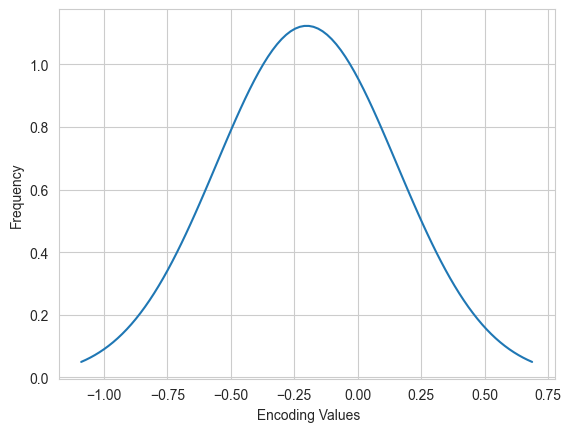

In [99]:
import matplotlib.pyplot as plt
import scipy.stats as stats
mu=mean
sigma=std
x=np.linspace(mu-2.5*sigma, mu + 2.5*sigma ,100)
plt.plot(x, stats.norm.pdf(x,mu,sigma))
plt.xlabel(" Encoding Values")
plt.ylabel("Frequency")
plt.show

7. >generate a hashtable  of randomly generated hash planes from gaussian distribution in a) above

In [100]:
# Generating random hash functions from the gaussian distribution
def generateHash(numHash,nbits,mean,std):
    #generates normal random numHash functions each of size nbits
    return np.random.normal(mean,std, size=(numHash,nbits))

In [101]:
## Testing code
#storeHashes=generateHash(encodingSize,Nbits,mean,std)
#for the purpose of this task, we are going to generate 100 different hash functions or hyperplanes
numOfHash=1113
storeHashes=generateHash(numOfHash,encodingSize,mean,std)
storeHashes

array([[-0.09255231, -0.33448071, -0.04884885, -0.00412833, -0.56025653,
        -0.55022356],
       [-0.80175268, -0.71318213, -0.23641607, -0.69780281, -0.05144293,
        -0.32987223],
       [-0.02201274, -0.07140194,  0.29474628, -0.0034239 , -0.24134525,
        -0.21185027],
       ...,
       [ 0.18647339, -0.12637359, -0.1071607 ,  0.04686746, -0.50620214,
        -0.09081543],
       [-0.80998659, -0.70039643, -0.59505855,  0.06547642, -0.01349893,
         0.40269987],
       [-0.13505374, -0.12807786, -0.15925206,  0.36026082, -0.75357558,
        -0.38983713]])

8. > if for each plane if a transaction is >=0 we put a value of 1 else 0 we end with a binary signature representation of the transaction.

In [102]:
#this version generates the signature based on hashes stored in the storedHashes array
def signatureGenerator(documents,storeHashes):
    print(f"document shape---> {documents.shape}")
    print('------------')
    print(f"Hash shape---> {storeHashes.shape}")
    print('------------')

    #h=storeHashes.transpose()
    documents=np.array(documents)
    docTrans=documents.transpose()



    signature=np.matmul(storeHashes,docTrans)
    #we need to encode the signature into bits (ie 1's and 0's)
    bitsignature=np.array([1 if i>=0 else 0 for items in signature for i in items]) #results in a flattened array
    bitsignature=bitsignature.reshape(signature.shape) #reshape it back to original shape of signature array

    return bitsignature


In [103]:
signatureArray=signatureGenerator(x_train_selected_scaled_Normalized,storeHashes)

print(signatureArray.shape)
print(signatureArray)

document shape---> (75000, 6)
------------
Hash shape---> (1113, 6)
------------
(1113, 75000)
[[1 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 [1 1 1 ... 1 1 1]]



9. > Divide signatures to  **B** bands of **r** rows each.

In [104]:
def split(signature,numBands:int):
    #assert that the entire signature can be divided into bands of equal length
    assert len(signature)%numBands==0
    # creating a placeholder to hold values for the subvector
    subvect=[]

    count=0
    r=len(signature)//numBands
    #loop through the signature matrix while moving r steps
    for i in range(0,len(signature),r):
        subvect.append(signature[i:i+r])
        count+=1

    print(count)
    return subvect

In [ ]:
print(len(signatureArray))

In [105]:
## Testing splitting
b=53
subvects=split(signatureArray,b)
numOfHash
print(len(subvects))
print(f"Number of Bands:==> {b}")
print(f"Number of rows per band:==> {numOfHash//b}")
print(f"Number of Buckets:==> {2**(numOfHash//b)} ")

53
53
Number of Bands:==> 53
Number of rows per band:==> 21
Number of Buckets:==> 2097152 


10. > hash bands into buckets.(elements in the same bucket are regarded as being identical

In [ ]:
#bands={}
def DecimalHashBandsIntoBucket(BandVect:list):
    bands={}
    for j in range(len(BandVect)):

        for i in range(BandVect[j].shape[1]):
            subsig=BandVect[j][:,i]
            #converting list of arrays to string
            strSubsig=''.join(str(x) for x in subsig)

            #converting binary to decimal representation
            bandID=int(strSubsig,2)

            if bandID not in bands.keys():
                bands[bandID]=[i]
            else:
                bands[bandID].append(i)
    return bands

DecimalHashBandsIntoBucket(subvects)

bands=DecimalHashBandsIntoBucket(subvects)
print(bands)

### Generating candidate pairs

In [ ]:
from itertools import combinations
# Generate a list of tuples containing just candidate pairs
def generateCandidatePairs(bands):
    #input: A bucket(dictionary) of bands with various candidates
    #Output: A list of tuples containing pairs of candidates
    candidatepairs=[]
    #extract values from bands that constitute a bucket
    candidates=bands.values()

    for candidate in candidates:
        if len(candidate)<=1: continue

        candidatepairs.extend(combinations(candidate,2))

    return list(set(candidatepairs))

#print(signatureMatrix[1:10,:])
#print(signatureMatrix[1:10,:].transpose())


candidatesPairs=generateCandidatePairs(bands)
print(candidatesPairs)

## Optimizing bands and visualization
 -- this constitute use selecting at random some signatures and verifying  if they are candidate pairs or not
 -- if they are candidates we plot at point 1 if not then their candidate statue is 0


In [ ]:
from sklearn.metrics.pairwise import  cosine_similarity

pairs=pd.DataFrame({
    'x':[],
    'y':[],
    'cosine':[],
    'candidates':[]
})
signatureMatrixTrans=signatureArray.transpose()
print(signatureMatrixTrans.shape)
data_len=signatureMatrixTrans.shape[0]
print(data_len)
sampleSize=45
choosen=set()

for _ in range(sampleSize):
    #x,y=np.random.choice(data_len,2)
    x,y=np.random.choice(data_len,2)
    if x==y or (x,y) in choosen: continue
    choosen.add((x,y))
    candidates=1 if (x,y) in candidatesPairs else 0

    vectorX=signatureMatrixTrans[x]

    vectorY=signatureMatrixTrans[y]

    cosine=cosine_similarity([vectorX],[vectorY])[0][0]
    #if cosine>0.75 and candidates==0: continue

    pairs=pairs.append({
        'x':x,
        'y':y,
        'cosine':cosine,
        'candidates':candidates
    },ignore_index=True)

cos_Min=pairs['cosine'].min()
cos_Max=pairs['cosine'].max()

pairs['cosine_norm'] = (pairs['cosine'] -cos_Min)/(cos_Max - cos_Min)




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=pairs, x='cosine', y='candidates', alpha=0.5)

In [ ]:
def probability(s, r, b):
    # s: similarity
    # r: rows (per band)
    # b: number of bands
    return 1 - (1 - s**r)**b

def normalize(x, x_min, x_max):
    return (x - x_min) / (x_max - x_min)

def treshold(r,b):
    return (1/b)**(1/r)

In [ ]:
b = 32
r = int(512 / b)
s_scores = np.arange(0.0, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

print(f"Probability:--> {probability(0.6,r,b)}")

print(f"treshold(t):--> {treshold(r,b)}")

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='cosine_norm', y='candidates', alpha=0.9, color='k')

In [ ]:
sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='cosine', y='candidates', alpha=0.9, color='k')

## testing different band sizes and their corresponding step functon

In [ ]:
probs=pd.DataFrame({
    'P':[],
    's':[],
    'b':[]
})
for b in [1113,371,159,53,21,7,3,1]:
    r = int(512 / b)
    s_scores = np.arange(0.0, 1, 0.001)
    P_scores = [probability(s, r, b) for s in s_scores]
    probs = probs.append(pd.DataFrame({
        'Probability (P)': P_scores,
        'cosine similarity(s)': s_scores,
        'band': [str(b)]*len(s_scores),


    }), ignore_index=True)

linegraph=sns.lineplot(data=probs, x='cosine similarity(s)', y='Probability (P)', hue='band')
#sns.scatterplot(data=pairs, x='cosine_norm', y='candidates', alpha=0.10,  color='red')
sns.scatterplot(data=pairs, x='cosine_norm', y='candidates',  color='green')
linegraph.legend_.set_title("Number of Bands (b)")
linegraph.set(title="Similarity to Probability S-Curve for mobile money Transactions")

11. > Testing phase.

## Testing LSH Methodology

### A) Take in a transaction or message as input

In [ ]:
t=x_train_selected.head(1)
print(t)

### B) Scale and normalize the transaction using thesame scheme used in training

- Define a function known as Normalize(which performs min max normalization for all attribute values)

In [ ]:
t_scale=scale(t)
t
